In [51]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

In [2]:
#Path to train images
Train_path_axial = Path('./axial_t1wce_2_class/images/train')
Train_path_coronal = Path('./coronal_t1wce_2_class/images/train')
Train_path_sagittal = Path('./sagittal_t1wce_2_class/images/train')

#Path to test images
Test_path_axial = Path('./axial_t1wce_2_class/images/test')
Test_path_coronal = Path('./coronal_t1wce_2_class/images/test')
Test_path_sagittal = Path('./sagittal_t1wce_2_class/images/test')


In [47]:
df = pd.read_csv('./axial_t1wce_2_class/labels/train/00095_170.txt',sep = ' ',names=["MGMT", "x1", "x2", "x3", "x4"], header = None)
img = cv2.imread('./axial_t1wce_2_class/images/train/00095_170')

with open('./axial_t1wce_2_class/labels/train/00095_170.txt', encoding="utf-8") as f:
    for line in f:
        num = list(map(float,line.split(" "))) #  line.split("\t") if numbers are seperated by tab
        print(num)
        for i in num:
            i = i * 255
            bb.append(i)
        print(num)
print(bb)
np.delete(bb,0)

[0.0, 0.428991, 0.361502, 0.144366, 0.150235]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [28]:
def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.shape[0], im.shape[1]
    size = max(x, y)
    BLACK = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im,int((size-y)/2),int((size-y)/2),int((size-x)/2),int((size-x)/2),cv2.BORDER_CONSTANT, value = BLACK)
    return new_im

In [53]:
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
temp_array  = []
image_size = 180
for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        print(img.shape)
        X_train.append(img)
image_index = 0
bb_train = np.zeros((len(X_train),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])
            image_index += 1

X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
image_index = 0
bb_test = np.zeros((len(X_test),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])
            image_index += 1

 83%|█████████████████████████████████████████████████████████████████             | 247/296 [00:00<00:00, 1236.93it/s]

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
384
(180, 180, 3)
384
(180, 180, 3)
384
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
320
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180

100%|██████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 1251.33it/s]


256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)
256
(180, 180, 3)


 24%|██████████████████▊                                                             | 75/318 [00:00<00:00, 747.77it/s]

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 

 68%|█████████████████████████████████████████████████████▉                         | 217/318 [00:00<00:00, 649.19it/s]

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 

100%|███████████████████████████████████████████████████████████████████████████████| 318/318 [00:00<00:00, 661.98it/s]


(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)


 26%|████████████████████▌                                                           | 68/264 [00:00<00:00, 675.45it/s]

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 

 78%|█████████████████████████████████████████████████████████████▎                 | 205/264 [00:00<00:00, 670.55it/s]

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)


100%|███████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 663.23it/s]

(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)
(180, 180, 3)



100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 6463.29it/s]


In [49]:
len(X_test)

223

([], [])

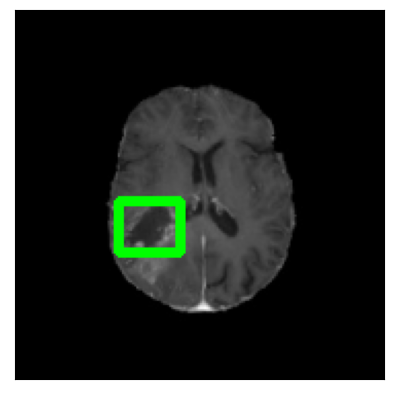

In [56]:
# Draw the bounding boxes
if len(bb_test[12]) == 4:
    xmin, ymin, height, width = bb_test[12]
    img = cv2.rectangle(X_test[12], (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (0, 255, 0), 3)

plt.imshow(img)
plt.xticks([])
plt.yticks([])

In [57]:
#prepare dataset 
train_dataset = ImageDataGenerator()

In [58]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [60]:
X_train, bb = shuffle(X_train, bb_train)

In [61]:
BATCH_SIZE = 16
train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)

In [ ]:
model.fit(
        data_generator(),
        epochs=20,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]